# ECCOv4r3 monthly mean heat budget

In [1]:
import numpy as np
import xarray as xr
import gcsfs
import xgcm

import matplotlib.pyplot as plt
%matplotlib inline

## Load dataset
The ECCOv4 release 3 dataset includes both monthly averaged data and snapshots (`_snp`). Time points are set in the middle of the month for averages and at the beginning and end of the month for snapshots. ECCOv4r3 solution has been run from 1992 to 2015.

In [2]:
ds = xr.open_zarr(gcsfs.GCSMap('pangeo-data/ecco/eccov4r3'))

In [3]:
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    PHrefC     (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    PHrefF     (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    XC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    XG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    Z          (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zl         (k_l) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zp1        (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    Zu         (k_u) float32 dask.array<

## Creating the grid object

In [4]:
face_connections = {'face':
                    {0: {'X':  ((12, 'Y', False), (3, 'X', False)),
                         'Y':  (None,             (1, 'Y', False))},
                     1: {'X':  ((11, 'Y', False), (4, 'X', False)),
                         'Y':  ((0, 'Y', False),  (2, 'Y', False))},
                     2: {'X':  ((10, 'Y', False), (5, 'X', False)),
                         'Y':  ((1, 'Y', False),  (6, 'X', False))},
                     3: {'X':  ((0, 'X', False),  (9, 'Y', False)),
                         'Y':  (None,             (4, 'Y', False))},
                     4: {'X':  ((1, 'X', False),  (8, 'Y', False)),
                         'Y':  ((3, 'Y', False),  (5, 'Y', False))},
                     5: {'X':  ((2, 'X', False),  (7, 'Y', False)),
                         'Y':  ((4, 'Y', False),  (6, 'Y', False))},
                     6: {'X':  ((2, 'Y', False),  (7, 'X', False)),
                         'Y':  ((5, 'Y', False),  (10, 'X', False))},
                     7: {'X':  ((6, 'X', False),  (8, 'X', False)),
                         'Y':  ((5, 'X', False),  (10, 'Y', False))},
                     8: {'X':  ((7, 'X', False),  (9, 'X', False)),
                         'Y':  ((4, 'X', False),  (11, 'Y', False))},
                     9: {'X':  ((8, 'X', False),  None),
                         'Y':  ((3, 'X', False),  (12, 'Y', False))},
                     10: {'X': ((6, 'Y', False),  (11, 'X', False)),
                          'Y': ((7, 'Y', False),  (2, 'X', False))},
                     11: {'X': ((10, 'X', False), (12, 'X', False)),
                          'Y': ((8, 'Y', False),  (1, 'X', False))},
                     12: {'X': ((11, 'X', False), None),
                          'Y': ((9, 'Y', False),  (0, 'X', False))}}}

In [5]:
grid = xgcm.Grid(ds, face_connections=face_connections)

In [6]:
grid

<xgcm.Grid>
Z Axis (periodic):
  * center   k (50) --> left
  * left     k_l (50) --> center
  * outer    k_p1 (51) --> center
  * right    k_u (50) --> center
X Axis (periodic):
  * center   i (90) --> left
  * left     i_g (90) --> center
T Axis (periodic):
  * center   time (288) --> inner
  * inner    time_snp (287) --> center
Y Axis (periodic):
  * center   j (90) --> left
  * left     j_g (90) --> center

## Create and Connect to Dask Distributed Cluster

In [7]:
from dask.distributed import Client, progress

from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=30)
cluster

In [8]:
client = Client(cluster)
client

Client Scheduler: tcp://10.20.0.57:33504 Dashboard: /user/jetesdal/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Define terms
Before doing the budget calculations we need to define some terms that will be used in the budget calculations.

### Number of seconds between each snapshot
There are no snapshots for the first and last time point. Thus, we are skipping budget calculations for first and last month of the given time period.

In [9]:
dt = ds.time_snp[1:].load()
# delta t in seconds. Note: devide by 10**9 to convert nanoseconds to seconds
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]

# Rename time (and iter) axis
dt = dt.rename({'time_snp':'time','iter_snp':'iter'})

# time axis of dt should be the same as of the monthly averages
dt.time.values = ds.time[1:-1].values

### Relevant constants

In [10]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62
zeta1 = 0.6
zeta2 = 20.0

### Ocean depth

In [11]:
# Ocean depth (m)
Depth = ds.Depth

### Grid dimensions

In [12]:
dxG = ds.dxG
dyG = ds.dyG
drF = ds.drF

rA = ds.rA
hFacC = ds.hFacC.load()

### Volume

In [13]:
# Volume (m^3)
vol = (rA*drF*hFacC).transpose('face','k','j','i')

### Land mask 

In [14]:
# Make copy of hFacC
mskC = hFacC.copy(deep=True).load()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

In [15]:
# Make 2D land mask for surface (This is just for plotting/mapping purposes)
land_mask = mskC[0]
land_mask.values[land_mask.values==0] = np.nan

## Evaluating the heat budget
$$G^{\theta,tot} = G^{\theta,adv} + G^{\theta,forc} + G^{\theta,diff}$$
$$\frac{\partial(s^*\theta)}{\partial t} = -\nabla_{z^*}(s^*\,\theta\,{\bf v_{res}}) - \frac{\partial(\theta\,w_{res})}{\partial z^*} + s^*\,F_{\theta} + s^*\,D_{\theta}$$

### Total tendency
- THETA: Potential Temperature (degC)

In [19]:
# Load snapshots for surface height anomaly from dataset
ETANsnp = ds.ETAN_snp

# Load snapshots of theta
THETAsnp = ds.THETA_snp

In [20]:
# Calculate the s∗theta term
HCsnp = (THETAsnp*(1+ETANsnp/Depth)).transpose('time_snp','face','k','j','i')

In [21]:
# Total tendency (degC/s)
tendH = grid.diff(HCsnp, 'T', boundary='fill', fill_value=0.0)/dt

# Add coordinates
tendH['Depth'] = ds.Depth
tendH['XC'] = ds.XC
tendH['YC'] = ds.YC
tendH['Z'] = ds.Z
tendH['rA'] = ds.rA
tendH['PHrefC'] = ds.PHrefC
tendH['drF'] = ds.drF
tendH['hFacC'] = ds.hFacC

tendH = xr.concat([np.nan*xr.zeros_like(vol).assign_coords(time=ds.time[0]).expand_dims('time'),tendH,
                   np.nan*xr.zeros_like(vol).assign_coords(time=ds.time[-1]).expand_dims('time')],
                  dim='time').transpose('time','face','k','j','i')

### Forcing
- TFLUX: total heat flux (match heat-content variations) (W/m^2)
- oceQsw: net Short-Wave radiation (+=down) (W/m^2)

In [22]:
# Load monthly averages of heat flux and shortwave radiation
TFLUX = ds.TFLUX
oceQsw = ds.oceQsw

#### Defining terms needed for evaluating surface heat forcing

In [23]:
Z = ds.Z.load()
RF = np.concatenate([ds.Zp1.values[:-1],[np.nan]])

**Note**: `Z` and `Zp1` are used in deriving surface heat penetration. MATLAB code uses `RF` from `mygrid` structure.

In [24]:
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

In [25]:
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

In [26]:
# Save q1 and q2 as xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

#### Compute vertically penetrating flux

In [27]:
# Surface heat flux (below the surface)
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*oceQsw).transpose('time','face','k','j','i')

In [28]:
# Surface heat flux (at the sea surface)
forcH_surf = ((TFLUX - (1-(q1[0]-q2[0]))*oceQsw)*mskC[0]).transpose('time','face','j','i').assign_coords(k=0).expand_dims('k')

In [29]:
forcH = xr.concat([forcH_surf,forcH_subsurf[:,:,1:]], dim='k').transpose('time','face','k','j','i')

#### Add geothermal heat flux
Geothermal flux needs to be a three dimensional field since the sources are distributed along the ocean floor at various depths. This requires a three dimensional mask.

In [30]:
# Create 3d bathymetry mask
mskC_shifted = mskC.shift(k=-1)

In [31]:
mskC_shifted.values[-1,:,:,:] = 0
mskb = mskC - mskC_shifted

In [32]:
# Create 3d field of geothermal heat flux
geoflx3d = ds.GEOFLX * mskb.transpose('face','k','j','i')
GEOFLX = geoflx3d.transpose('face','k','j','i')

In [33]:
# Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
forcH = ((forcH + GEOFLX)/(rhoconst*c_p))/(hFacC*drF)

### Advection
#### Horizontal convergence
- ADVx_TH: U Comp. Advective Flux of Pot.Temperature (degC m^3/s)
- ADVy_TH: V Comp. Advective Flux of Pot.Temperature (degC m^3/s)

In [34]:
ADVx_TH = ds.ADVx_TH
ADVy_TH = ds.ADVy_TH

In [35]:
ADVxy_diff = grid.diff_2d_vector({'X' : ADVx_TH, 'Y' : ADVy_TH}, boundary = 'fill')

In [36]:
ADVx_diffx = ADVxy_diff['X']
ADVy_diffy = ADVxy_diff['Y']

In [37]:
# Convergence of horizontal advection (degC/s)
adv_hConvH = (-(ADVx_diffx + ADVy_diffy)/vol).transpose('time','face','k','j','i')

#### Vertical convergence
- ADVr_TH: Vertical Advective Flux of Pot.Temperature (degC m^3/s)

In [38]:
# Load monthly averages of vertical advective flux
ADVr_TH = ds.ADVr_TH.transpose('time','face','k_l','j','i')

For `ADVr_TH`, `DFrE_TH` and `DFrI_TH`, we need to make sure that sequence of dimensions are consistent. When loading the fields use `.transpose('time','face','k_l','j','i')`. Otherwise, the divergences will be not correct (at least for face = 12).

In [39]:
# Convergence of vertical advection (degC/s)
adv_vConvH = (grid.diff(ADVr_TH, 'Z', boundary='fill')/vol).transpose('time','face','k','j','i')

The heat budget only balances when the sea surface forcing is not added to the vertical advective flux (at the air-sea interface). This is different from the volume and salinity budget.

### Diffusion
#### Horizontal convergence
- DFxE_TH: U Comp. Diffusive Flux of Pot.Temperature (degC m^3/s)
- DFyE_TH: V Comp. Diffusive Flux of Pot.Temperature (degC m^3/s)

In [40]:
# Load monthly averages of diffusive fluxes
DFxE_TH = ds.DFxE_TH
DFyE_TH = ds.DFyE_TH

In [41]:
DFxyE_diff = grid.diff_2d_vector({'X' : DFxE_TH, 'Y' : DFyE_TH}, boundary = 'fill')

In [42]:
DFxE_diffx = DFxyE_diff['X']
DFyE_diffy = DFxyE_diff['Y']

In [43]:
# Convergence of horizontal diffusion (degC/s)
dif_hConvH = (-(DFxE_diffx + DFyE_diffy)/vol).transpose('time','face','k','j','i')

#### Vertical convergence
- DFrE_TH: Vertical Diffusive Flux of Pot.Temperature (Explicit part) (degC m^3/s)
- DFrI_TH: Vertical Diffusive Flux of Pot.Temperature (Implicit part) (degC m^3/s)

In [44]:
# Load monthly averages of vertical diffusive fluxes
DFrE_TH = ds.DFrE_TH.transpose('time','face','k_l','j','i')
DFrI_TH = ds.DFrI_TH.transpose('time','face','k_l','j','i')

In [45]:
# Convergence of vertical diffusion (degC/s)
dif_vConvH = ((grid.diff(DFrE_TH, 'Z', boundary='fill') + \
              grid.diff(DFrI_TH, 'Z', boundary='fill'))/vol).transpose('time','face','k','j','i')

### Monthly mean climatology

In [54]:
tendH_clim = tendH.groupby('time.month').mean('time')
forcH_clim = forcH.groupby('time.month').mean('time')
adv_hConvH_clim = adv_hConvH.groupby('time.month').mean('time')
adv_vConvH_clim = adv_vConvH.groupby('time.month').mean('time')
dif_hConvH_clim = dif_hConvH.groupby('time.month').mean('time')
dif_vConvH_clim = dif_vConvH.groupby('time.month').mean('time')

### Monthly mean anomaly

In [65]:
tendH_anom = tendH.groupby('time.month') - tendH_clim
forcH_anom = forcH.groupby('time.month') - forcH_clim

In [70]:
forcH_anom = forcH_anom.load()

KilledWorker: ("('getitem-transpose-05d8e3ac89eb38909f7c49cb37020b11', 0, 0, 1, 0, 0)", 'tcp://10.21.15.5:35017')

KilledWorker: ("('transpose-getitem-98feb17225ed3af7f1a4f66961dd5da2', 0)", 'tcp://10.20.233.7:42204')

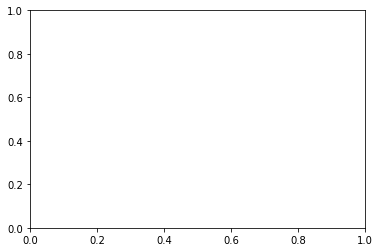

In [69]:
forcH_anom[:,1,1,10,10].plot()

### Total convergences

In [55]:
# Total convergence of advective flux
adv_ConvH_clim = adv_hConvH_clim + adv_vConvH_clim

# Total convergence of diffusive flux
dif_ConvH_clim = dif_hConvH_clim + dif_vConvH_clim

# Total convergence
ConvH_clim = adv_ConvH_clim + dif_ConvH_clim

### Total tendency

In [56]:
totalH_clim = ConvH_clim + forcH_clim

### Time series for an arbitrarily chosen grid point

In [57]:
f = 12
k = 1
j = 10
i = 10

In [59]:
tendH_clim

<xarray.DataArray (month: 12, face: 13, k: 50, j: 90, i: 90)>
dask.array<shape=(12, 13, 50, 90, 90), dtype=float64, chunksize=(1, 13, 50, 90, 90)>
Coordinates:
    Depth    (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    XC       (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    YC       (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    rA       (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    PHrefC   (k) float32 49.05 147.15 245.25 343.35 441.45 539.55 637.65 ...
    Z        (k) float32 -5.0 -15.0 -25.0 -35.0 -45.0 -55.0 -65.0 -75.005 ...
    drF      (k) float32 10.0 10.0 10.0 10.0 10.0 10.0 10.0 10.01 10.03 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  

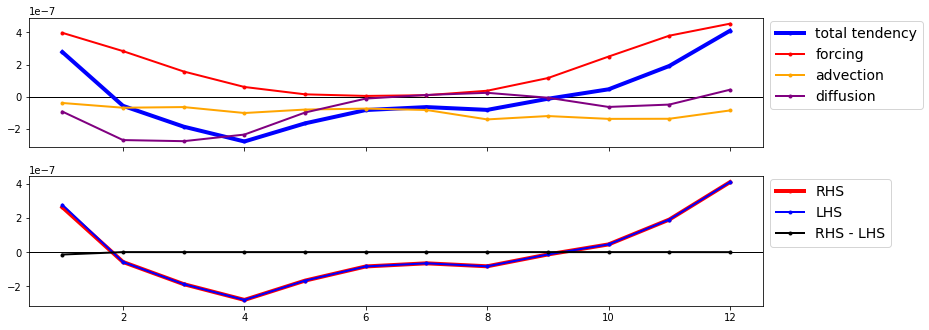

In [62]:
fig, axes = plt.subplots(2, 1,figsize=(12,5))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(tendH_clim.month, tendH_clim[:,f,k,j,i], lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcH_clim.month, forcH_clim[:,f,k,j,i], lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvH_clim.month, adv_ConvH_clim[:,f,k,j,i], lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvH_clim.month, dif_ConvH_clim[:,f,k,j,i], lw=2, color='purple', marker='.',label='diffusion')
plt.setp(plt.gca(), 'xticklabels',[])
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 1.03))

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(totalH_clim.month, totalH_clim[:,f,k,j,i], lw=4, color='red', marker='.',label='RHS')
plt.plot(tendH_clim.month, tendH_clim[:,f,k,j,i], lw=2, color='blue', marker='.',label='LHS')
plt.plot(tendH_clim.month, totalH_clim[:,f,k,j,i]-tendH_clim[:,f,k,j,i], lw=2, color='k', marker='.',label='RHS - LHS')
plt.legend(fontsize=14,bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9)
plt.show()

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


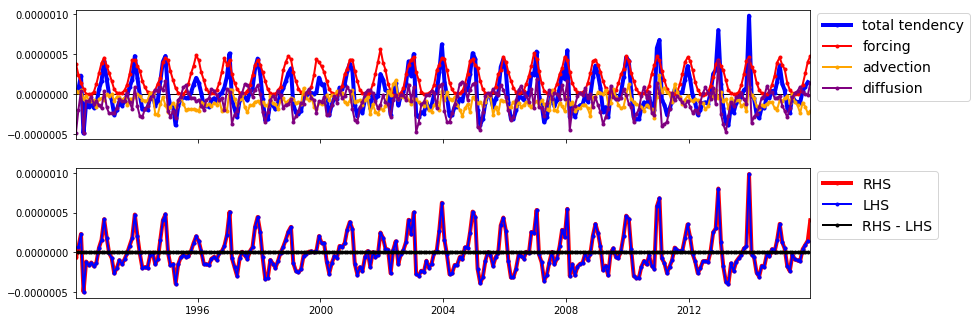

### Verical profiles for an arbitrarily chosen grid point

In [71]:
t = 1

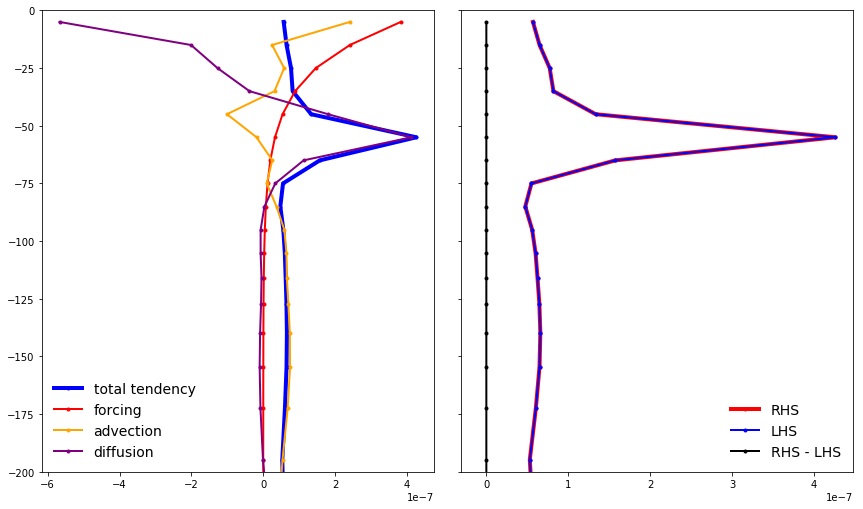

In [72]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12,7))
fig.tight_layout()

plt.subplot(1, 2, 1)
plt.plot(tendH[t,f,:,j,i],tendH.Z, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(forcH[t,f,:,j,i],forcH.Z, lw=2, color='red', marker='.',label='forcing')
plt.plot(adv_ConvH[t,f,:,j,i],adv_ConvH.Z, lw=2, color='orange', marker='.',label='advection')
plt.plot(dif_ConvH[t,f,:,j,i],dif_ConvH.Z, lw=2, color='purple', marker='.',label='diffusion')
plt.legend(loc='lower left',frameon=False,fontsize=14)
plt.ylim([-200,0])

plt.subplot(1, 2, 2)
plt.plot(totalH[t,f,:,j,i],totalH.Z, lw=4, color='red', marker='.',label='RHS')
plt.plot(tendH[t,f,:,j,i],tendH.Z, lw=2, color='blue', marker='.',label='LHS')
plt.plot(totalH[t,f,:,j,i]-tendH[t,f,:,j,i],tendH.Z, lw=2, color='k', marker='.',label='RHS - LHS')
plt.setp(plt.gca(), 'yticklabels',[])
plt.legend(loc='lower right',frameon=False,fontsize=14)
plt.ylim([-200,0])

plt.show()